In [1]:
import geetools
import ee
import geemap
import random
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import math
import os
from datetime import datetime
import skimage
import time
from A1_landsat_functions import *

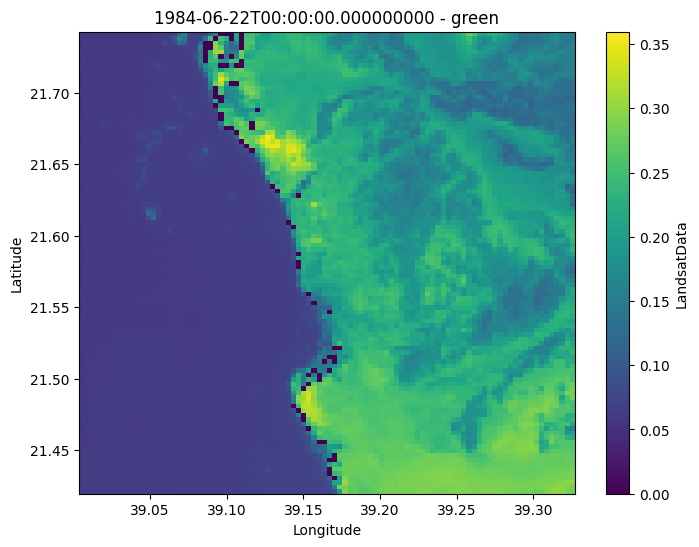

In [3]:
ds = xr.open_dataset('/mnt/datawaha/hyex/gahwagrw/SaudiUHI/jd_landsat.nc')

time_index = 1
band_index = 1  

da = ds["LandsatData"].isel(time=time_index, band=band_index)

plt.figure(figsize=(8, 6))
da.plot(cmap='viridis')
plt.title(f"{ds.time[time_index].values} - {ds.band[band_index].values}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [29]:
#remove dublicate dates 
_, unique_idx = np.unique(times, return_index=True)
ds = ds.isel(time=unique_idx)

In [41]:
lst = ds['LandsatData'].sel(band='LST')
ndvi = ds_unique['LandsatData'].sel(band='NDVI')
ndbi = ds['LandsatData'].sel(band='NDBI')

In [59]:
#exclude the red sea 
ndwi = ds['LandsatData'].sel(band='NDWI')  

water_mask = ndwi > 0  # water pixels usually have high NDWI
land_mask = ~water_mask

lst = lst.where(land_mask)
ndbi = ndbi.where(land_mask)


In [60]:
print(lst.min().values, lst.max().values)


-14.999927276970825 60.999950712017


In [67]:
# prepare urban masks 
#chose 0.1 based on this https://www.sciencedirect.com/science/article/pii/S1040618220303530
urban_mask = (ndbi > 0.1) #& (ndvi < 0.3)
urban_mask = urban_mask.broadcast_like(lst)


# Urban and rural means (vectorized, keeping time dimension)
urban_mean = lst.where(urban_mask).mean(dim=('lat', 'lon'))
rural_mean = lst.where(~urban_mask).mean(dim=('lat', 'lon'))

suhi = urban_mean - rural_mean

# Combine into DataFrame
df_suhi = pd.DataFrame({
    'time': ds['time'].values,
    'urban_mean': urban_mean.to_numpy(),
    'rural_mean': rural_mean.to_numpy(),
    'SUHI': suhi.to_numpy()
})



In [68]:
print(df_suhi.tail())

          time  urban_mean  rural_mean       SUHI
865 2025-05-06   37.992328   46.584173  -8.591845
866 2025-05-22   50.074258   26.568873  23.505385
867 2025-06-07   44.259950   54.280482 -10.020531
868 2025-06-23   49.128982   49.767878  -0.638896
869 2025-07-09   55.734594   42.596212  13.138382


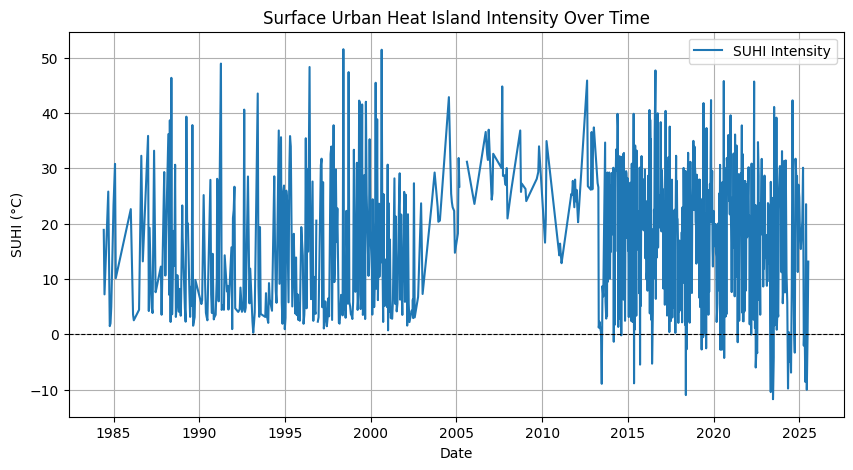

In [69]:
from skimage.filters import threshold_otsu

# Time series plot
plt.figure(figsize=(10,5))
plt.plot(df_suhi['time'], df_suhi['SUHI'], label='SUHI Intensity')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('SUHI (°C)')
plt.title('Surface Urban Heat Island Intensity Over Time')
plt.legend()
plt.grid(True)
plt.show()

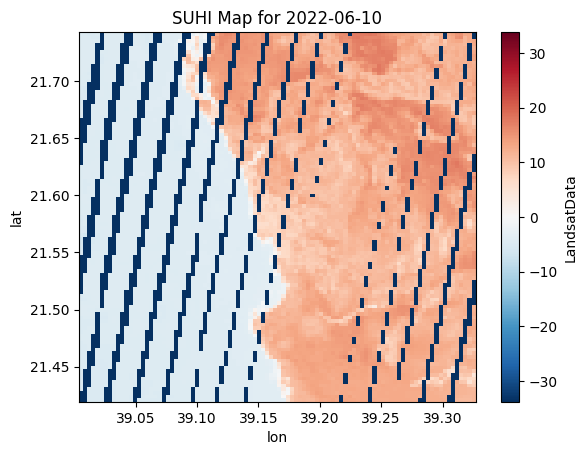

In [35]:
# 1. Ensure time is datetime
lst['time'] = pd.to_datetime(lst['time'].values)

#  select nearest date
date_sel = '2022-06-10'
lst_sel = lst.sel(time=date_sel, method='nearest')
urban_mask_sel = urban_mask.sel(time=date_sel, method='nearest')

# 4. Calculate SUHI map for that date
rural_mean_sel = lst_sel.where(~urban_mask_sel).mean()
suhi_map = lst_sel - rural_mean_sel

# Plot
suhi_map.plot()
plt.title(f"SUHI Map for {pd.to_datetime(lst_sel.time.values).date()}")
plt.show()


In [57]:
urban_lst = lst.sel(time=t).where(urban_mask)
rural_lst = lst.sel(time=t).where(~urban_mask)
urban_count = urban_lst.count().item()
rural_count = rural_lst.count().item()
print(f"Valid urban pixels: {urban_count}, valid rural pixels: {rural_count}")

Valid urban pixels: 497588, valid rural pixels: 7564702
